## Volatility Forecasting

Prediciting short term volatility forecasting between 1 to 5-days forecast and comparing between traditional models with deep learning models

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [5]:
spy_data = yf.download(["^GSPC"],start="2018-01-01", end="2024-12-31", auto_adjust = False)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [6]:
spy_data = spy_data.rename(columns={"^GSPC":"S&P500"})

In [7]:
spy_data.head()

Ticker,S&P500
Date,
2018-01-02,2695.810059
2018-01-03,2713.060059
2018-01-04,2723.989990
2018-01-05,2743.149902
2018-01-08,2747.709961


In [8]:
# Loading the VIX data for reference
vix = yf.Ticker("^VIX")
vix_data = vix.history(start="2018-01-01", end="2024-12-31")
vix_data.reset_index(inplace=True)

In [9]:
vix_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02 00:00:00-06:00,10.95,11.07,9.52,9.77,0,0.0,0.0
1,2018-01-03 00:00:00-06:00,9.56,9.65,8.94,9.15,0,0.0,0.0
2,2018-01-04 00:00:00-06:00,9.01,9.31,8.92,9.22,0,0.0,0.0
3,2018-01-05 00:00:00-06:00,9.10,9.54,9.00,9.22,0,0.0,0.0
4,2018-01-08 00:00:00-06:00,9.61,9.89,9.32,9.52,0,0.0,0.0


For ETFs like SPY the close and adjusted close are usually small and since this project is concerned with modelling volatility and not price return we would stick to using the Close as a parameter

In [11]:
len(spy_data)

1760

In [12]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2018-01-02 to 2024-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S&P500  1760 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB


In [13]:
spy_data.describe()

Ticker,S&P500
count,1760.000000
mean,3850.096284
std,918.010056
min,2237.399902
25%,2933.377441
50%,3907.449951
75%,4449.314941
max,6090.270020


##### Return Distribution

In [15]:
df_returns = (np.log(spy_data) - np.log(spy_data.shift(1))).dropna()

In [16]:
df_returns.head()

Ticker,S&P500
Date,
2018-01-03,0.006378
2018-01-04,0.004021
2018-01-05,0.007009
2018-01-08,0.001661
2018-01-09,0.001302


In [17]:
np.mean(df_returns)

0.00044595178134704006

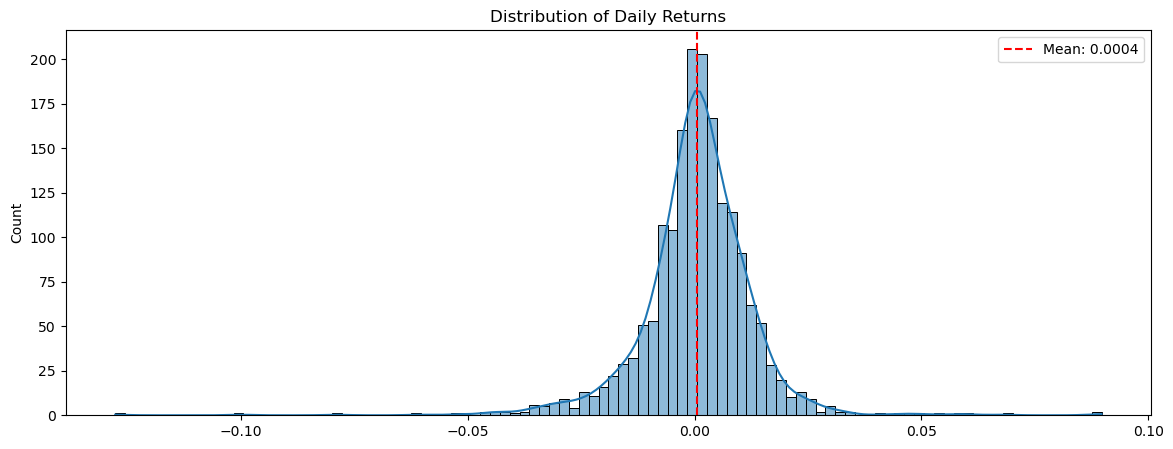

In [18]:
plt.figure(figsize=(14,5))
sns.histplot(df_returns, kde=True, bins=100)
plt.title("Distribution of Daily Returns")
plt.axvline(np.mean(df_returns), color="r", linestyle="--", label=f"Mean: {np.mean(df_returns):.4f}")
plt.legend()

In [19]:
from scipy.stats import jarque_bera

jb_stat, p_value = jarque_bera(df_returns)
print(f"Jarque-Bera p-value: {p_value:.8f}")  # p < 0.05 → Not normal

Jarque-Bera p-value: 0.00000000


In [20]:
print(f"Skewness: {df_returns["S&P500"].skew():.4f}")  # Negative → Left tail
print(f"Excess Kurtosis: {df_returns["S&P500"].kurtosis()-3:.4f}")  # >3 → Fat tails

Skewness: -0.8168
Excess Kurtosis: 11.4594


The distribution of the S&P returns shows that it is not symmetric and moderately negatively skewed. This means that returns are moderately positive, but investors should be on the lookout for large losses (although they don't happen frequently) but more likely than large gains.
The excess kurtosis of 8.6875 indicates heavy tail - to the left in this case due to the presence of extreme values or outliers.
Due to these observations statistical methods that assume normality would not be appropriate for modeling or analysis

#### Range

In [23]:
spy = yf.Ticker("^GSPC")
spy_data = spy.history(start="2018-01-01", end="2024-12-31")
spy_data.reset_index(inplace=True)

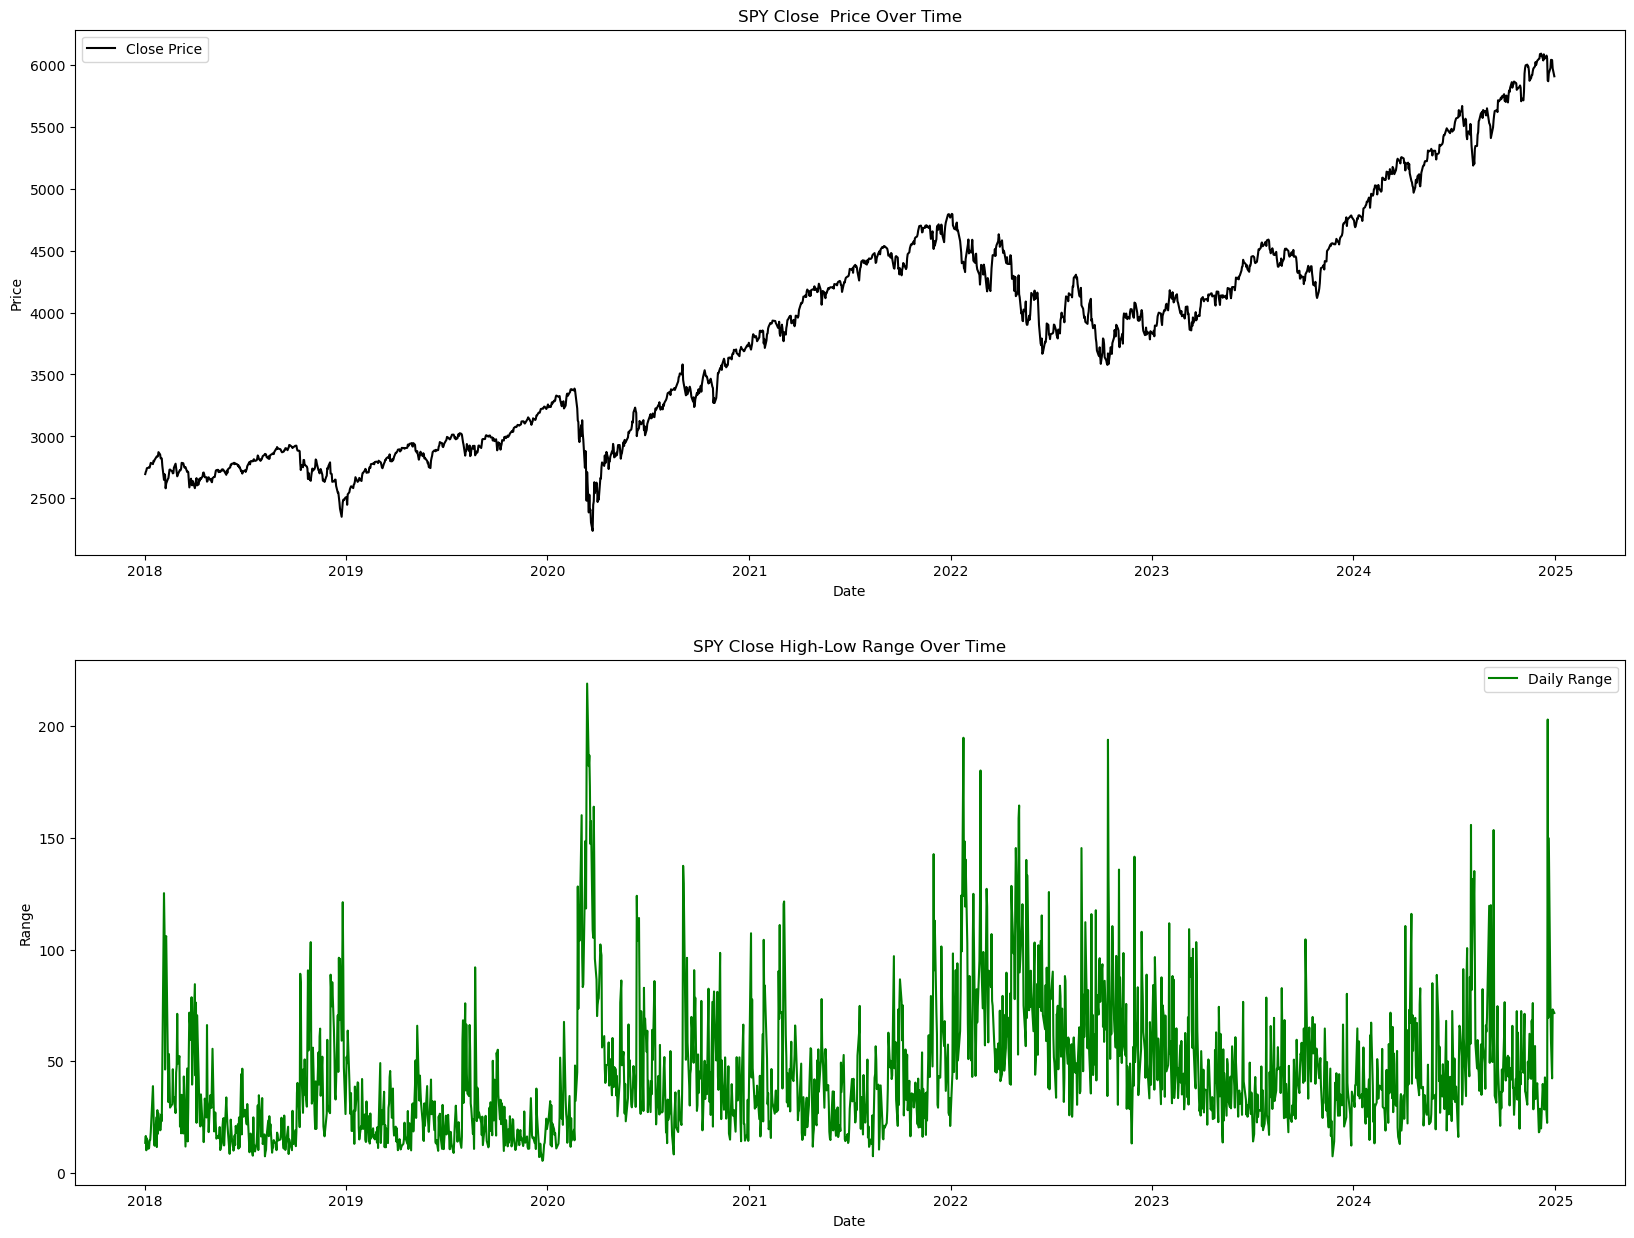

In [24]:
spy_data["Range"] = spy_data["High"] - spy_data["Low"]

fig, ax = plt.subplots(2,1, figsize=(20,15))
ax[0].plot(spy_data["Date"], spy_data["Close"], label="Close Price", color='black')
ax[0].set_title("SPY Close  Price Over Time")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].legend()

ax[1].plot(spy_data["Date"], spy_data["Range"], label="Daily Range", color="green")
ax[1].set_title("SPY Close High-Low Range Over Time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Range")
ax[1].legend()


plt.show();



This trend shows that the SPY has been on a bullish trend since 2020 where there was the dip due to the Covid-19 pandemic, where we also notice a high range in price 

#### Volatility Clustering

In [27]:
from statsmodels.tsa.stattools import acf

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

The autocorrelation function helps determine whether past volatility influences future volatility

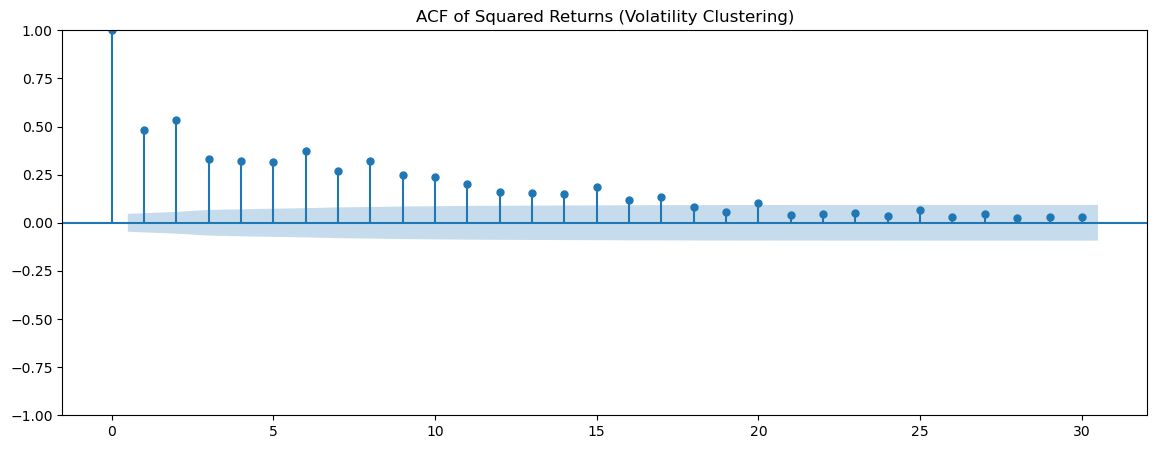

In [30]:
# Autocorrelation of squared returns
returns = df_returns["S&P500"]

fig, ax = plt.subplots(figsize=(14, 5)) 
plot_acf(returns**2, lags=30, alpha=0.05, title="ACF of Squared Returns (Volatility Clustering)", ax=ax) # Since volatility is unobserved r**2 is used not raw returns
plt.show()

This acf for understanding volatility cluster reveals that at most, volatility effects spills into at most 10 days with its siginificant effect still visible in day 1 and 2. The 95% confidence interval boundary indicated by the blue shaded region shows that the volatility is in no longer statistically significant beween days 18 onwards.

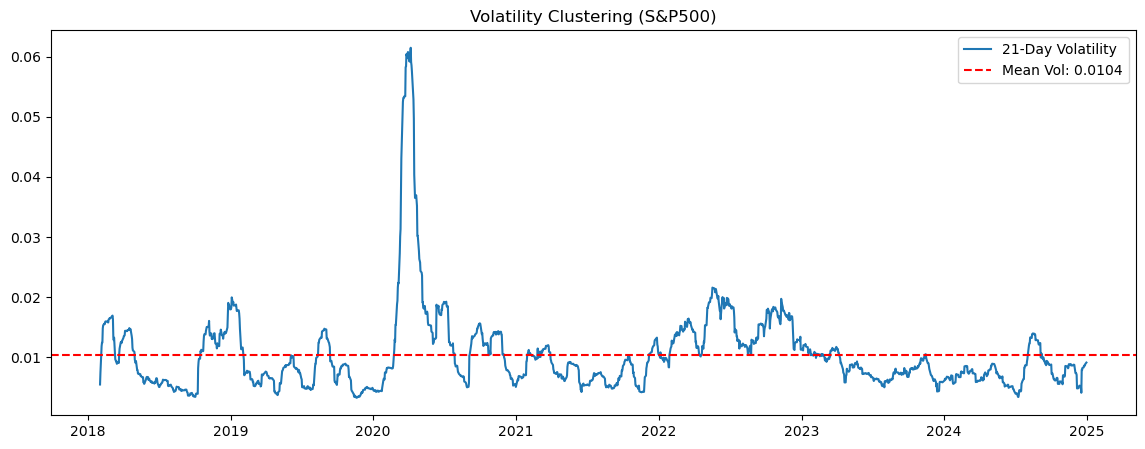

In [32]:
volatility = returns.rolling(21).std()

plt.figure(figsize=(14,5))
plt.plot(volatility.index, volatility, label="21-Day Volatility")
plt.title("Volatility Clustering (S&P500)")
plt.axhline(volatility.mean(), color='r', linestyle="--", label=f"Mean Vol: {volatility.mean():.4f}")
plt.legend()

#### Testing for Stationarity

This helps to determine if volatility changes around the mean significantly, highlighting moments in time when there was economic turbulence

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
def test_stationarity(series, name=None):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Value:")
    for k,v in result[4].items():
        print(f"{k}: {v:.4f}")

In [37]:
test_stationarity(returns, "Returns")

ADF Test for Returns
ADF Statistic: -12.8057
p-value: 0.0000
Critical Value:
1%: -3.4341
5%: -2.8632
10%: -2.5677


In [38]:
test_stationarity(volatility, "Volatility")

ADF Test for Volatility
ADF Statistic: -3.8751
p-value: 0.0022
Critical Value:
1%: -3.4342
5%: -2.8632
10%: -2.5677


The result of the stationarity test shows that the volatility series for the S&P 500 Index is fairly stationary (null hypothesis rejected) from the ADF score which is lesser than the critical values and also from the p value being less than 0.05. 

#### Regime Detection

In [41]:
from sklearn.cluster import KMeans

In [42]:
df_returns["Volatility"] = df_returns.rolling(21).std() * np.sqrt(252) # Annualized
df_returns["Returns_MA"] = df_returns["S&P500"].rolling(21).mean() # Smooth returns

In [43]:
X = df_returns[["Volatility", "Returns_MA"]].dropna()
kmeans = KMeans(n_clusters=3, random_state=16)
X["Regime"] = kmeans.fit_predict(X[["Volatility", "Returns_MA"]])

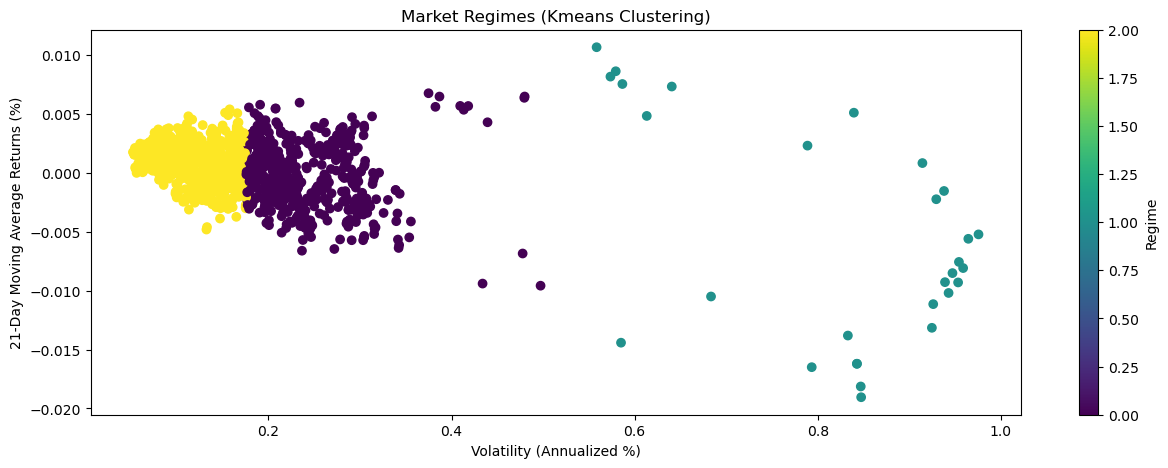

In [44]:
plt.figure(figsize=(15,5))
plt.scatter(X["Volatility"], X["Returns_MA"], c=X["Regime"], cmap="viridis")
plt.xlabel("Volatility (Annualized %)")
plt.ylabel("21-Day Moving Average Returns (%)")
plt.title("Market Regimes (Kmeans Clustering)")
plt.colorbar(label="Regime")
plt.show();

In [45]:
from sklearn.metrics import silhouette_score
print(f"Silhouette Score: {silhouette_score(X[['Volatility', 'Returns_MA']], X['Regime']):.2f}")

Silhouette Score: 0.64


In [46]:
# Better understand financial context of clustered regimes
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = ["Volatility", "Returns_MA"], index=["Regime 0", "Regime 1", "Regime 2"])

,Volatility,Returns_MA
Regime 0,0.237954,-0.000387
Regime 1,0.818006,-0.005558
Regime 2,0.113801,0.001002


#### **Regime 0: "Choppy Markets"**  
- **Volatility**: `0.237` (Moderate)  
- **Returns**: `-0.0004` (Neutral/Slightly Negative)  
- **Interpretation**:  
  - **Low-to-moderate volatility** with flat/negative returns.  
  - Typical of **sideways markets** or periods of uncertainty (e.g., Fed policy limbo).  

#### **Regime 2: "Bull Market"**  
- **Volatility**: `0.113` (Low)  
- **Returns**: `0.0010` (Positive)  
- **Interpretation**:  
  - **Low volatility + steady gains** → Classic *bull market* (e.g., 2017, 2019).  
  - Low risk, ideal for trend-following strategies.  

#### **Regime 1: "Crisis"**  
- **Volatility**: `0.818` (Very High)  
- **Returns**: `-0.0056` (Strongly Negative)  
- **Interpretation**:  
  - **Extreme volatility + losses** → *Market crashes* (e.g., COVID-19, 2008).  
  - High-risk regime; avoid leverage and hedge aggressively.

In [48]:
X.reset_index(inplace=True)

In [49]:
crisis_date = "2019-11-01"
X[X["Date"]>=crisis_date]["Regime"].value_counts()

Regime
2    845
0    424
1     29
Name: count, dtype: int64

## Feature Engineering

In [51]:
df_returns.head()

Ticker,S&P500,Volatility,Returns_MA
Date,,,
2018-01-03,0.006378,NaN,NaN
2018-01-04,0.004021,NaN,NaN
2018-01-05,0.007009,NaN,NaN
2018-01-08,0.001661,NaN,NaN
2018-01-09,0.001302,NaN,NaN


#### Lagged Features

In [53]:
# Lagged returns and volatility (1, 5, 21 days)
for lag in [1, 5, 21]:
    df_returns[f"Return_Lag_{lag}"] = df_returns["S&P500"].shift(lag)
    df_returns[f"Volatility_Lag_{lag}"] = df_returns["Volatility"].shift(lag)

#### Rolling Statistics

In [55]:
# Rolling extremes
df_returns["Rolling_Min_21"] = df_returns["S&P500"].rolling(21).min()
df_returns["Rolling_Max_21"] = df_returns["S&P500"].rolling(21).max()

# Rolling volatility rations
df_returns["Volatility_Ratio_5_21"] = (
    df_returns["S&P500"].rolling(5).std()/
    df_returns["S&P500"].rolling(21).std()
)

#### Technical Indicators

In [57]:
### RSI (momentum)
delta = df_returns["S&P500"].diff()
gain = delta.where(delta>0, 0)
loss = delta.where(delta<0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

df_returns["RSI"] = 100 - (100 / (1+avg_gain/avg_loss))

### Bollinger Bands
df_returns["MA_20"] = df_returns["S&P500"].rolling(20).mean() # Similar but different to Return_MA but for short trend trend while Return_MA is a mid-term baseline for volatility normalization and regime checks
df_returns["Upper_Band"] = df_returns["MA_20"] + 2 * df_returns["S&P500"].rolling(20).std()
df_returns["Lower_Band"] = df_returns["MA_20"] - 2 * df_returns["S&P500"].rolling(20).std()

In [58]:
df_returns.head()

Ticker,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,
2018-01-03,0.006378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.004021,NaN,NaN,0.006378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.007009,NaN,NaN,0.004021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.001661,NaN,NaN,0.007009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.001302,NaN,NaN,0.001661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Regime

In [60]:
df_returns_clean = df_returns.dropna(subset=["Volatility","Returns_MA"])

In [61]:
kmeans = KMeans(n_clusters=3, random_state=16)
df_returns_clean["Regime"] = kmeans.fit_predict(df_returns_clean[["Volatility", "Returns_MA"]])

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/1244744723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns_clean["Regime"] = kmeans.fit_predict(df_returns_clean[["Volatility", "Returns_MA"]])


In [62]:
df_returns_clean.Regime.value_counts()

Regime
2    1147
0     563
1      29
Name: count, dtype: int64

In [63]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = ["Volatility", "Returns_MA"], index=["Regime 0", "Regime 1", "Regime 2"])

,Volatility,Returns_MA
Regime 0,0.237954,-0.000387
Regime 1,0.818006,-0.005558
Regime 2,0.113801,0.001002


In [64]:
# Verify crisis dates are labeled correctly  
# crisis_date = pd.to_datetime("2020-03-16").tz_localize('America/New_York')  
print(df_returns_clean.loc["2020-03-16", 'Regime'])  # Should be 1

1.0


#### Macroeconomic Features

In [66]:
from fredapi import Fred

In [67]:
# Initialize the FRED API with your key
fred = Fred(api_key='d66f326e45966a51f8799ede96b679e5')

In [68]:
# List of Treasury yield series IDs
series_ids = ['DGS2', 'DGS10']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start=df_returns.index.min(), observation_end=df_returns.index.max())
    return data

# Get data for all series
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for clarity
yields.columns = ['2 Year', '10 Year']

In [69]:
len(yields)

1824

In [70]:
yields.head()

,2 Year,10 Year
2018-01-03,1.94,2.44
2018-01-04,1.96,2.46
2018-01-05,1.96,2.47
2018-01-08,1.96,2.49
2018-01-09,1.98,2.55


In [71]:
df_returns_clean.head()

Ticker,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band,Regime
Date,,,,,,,,,,,,,,,,,
2018-02-01,-0.000648,0.087191,0.002178,0.000489,NaN,0.000602,NaN,NaN,NaN,-0.010959,0.011772,1.570156,-605.081618,0.001968,0.013064,-0.009128,2
2018-02-02,-0.021437,0.118078,0.000854,-0.000648,0.087191,0.011772,NaN,0.006378,NaN,-0.021437,0.011772,1.196568,-164.513945,0.000695,0.015885,-0.014495,2
2018-02-05,-0.041843,0.188476,-0.001330,-0.021437,0.118078,-0.006755,NaN,0.004021,NaN,-0.041843,0.011772,1.473401,-120.936701,-0.001747,0.022298,-0.025792,0
2018-02-06,0.017291,0.197364,-0.000841,-0.041843,0.188476,-0.010959,NaN,0.007009,NaN,-0.041843,0.017291,1.835924,1168.807004,-0.000966,0.024518,-0.026450,0
2018-02-07,-0.005014,0.197652,-0.001159,0.017291,0.197364,0.000489,NaN,0.001661,NaN,-0.041843,0.017291,1.796488,-2725.336991,-0.001282,0.024241,-0.026804,0


In [72]:
len(df_returns_clean)

1739

In [73]:
df_returns_eco = pd.merge(df_returns_clean, yields, left_index=True, right_index=True, how="left")

In [74]:
df_returns_eco.head()

,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band,Regime,2 Year,10 Year
Date,,,,,,,,,,,,,,,,,,,
2018-02-01,-0.000648,0.087191,0.002178,0.000489,NaN,0.000602,NaN,NaN,NaN,-0.010959,0.011772,1.570156,-605.081618,0.001968,0.013064,-0.009128,2,2.16,2.78
2018-02-02,-0.021437,0.118078,0.000854,-0.000648,0.087191,0.011772,NaN,0.006378,NaN,-0.021437,0.011772,1.196568,-164.513945,0.000695,0.015885,-0.014495,2,2.15,2.84
2018-02-05,-0.041843,0.188476,-0.001330,-0.021437,0.118078,-0.006755,NaN,0.004021,NaN,-0.041843,0.011772,1.473401,-120.936701,-0.001747,0.022298,-0.025792,0,2.08,2.77
2018-02-06,0.017291,0.197364,-0.000841,-0.041843,0.188476,-0.010959,NaN,0.007009,NaN,-0.041843,0.017291,1.835924,1168.807004,-0.000966,0.024518,-0.026450,0,2.10,2.79
2018-02-07,-0.005014,0.197652,-0.001159,0.017291,0.197364,0.000489,NaN,0.001661,NaN,-0.041843,0.017291,1.796488,-2725.336991,-0.001282,0.024241,-0.026804,0,2.15,2.84


In [75]:
df_returns_eco["10Y-2Y Spread"] = df_returns_eco["10 Year"] - df_returns_eco["2 Year"]
df_returns_eco.drop(["10 Year", "2 Year"], axis=1, inplace=True)

In [76]:
df_returns_eco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1739 entries, 2018-02-01 to 2024-12-30
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   S&P500                 1739 non-null   float64
 1   Volatility             1739 non-null   float64
 2   Returns_MA             1739 non-null   float64
 3   Return_Lag_1           1739 non-null   float64
 4   Volatility_Lag_1       1738 non-null   float64
 5   Return_Lag_5           1739 non-null   float64
 6   Volatility_Lag_5       1734 non-null   float64
 7   Return_Lag_21          1738 non-null   float64
 8   Volatility_Lag_21      1718 non-null   float64
 9   Rolling_Min_21         1739 non-null   float64
 10  Rolling_Max_21         1739 non-null   float64
 11  Volatility_Ratio_5_21  1739 non-null   float64
 12  RSI                    1739 non-null   float64
 13  MA_20                  1739 non-null   float64
 14  Upper_Band             1739 non-null  

In [77]:
vix = yf.download("^VIX", start=df_returns.index.min(), end=df_returns.index.max())["Close"]
vix.head()

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/4113272670.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=df_returns.index.min(), end=df_returns.index.max())["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker,^VIX
Date,
2018-01-03,9.15
2018-01-04,9.22
2018-01-05,9.22
2018-01-08,9.52
2018-01-09,10.08


In [78]:
df_returns_eco = pd.merge(df_returns_eco, vix, left_index=True, right_index=True, how="left")

In [79]:
df_returns_eco = df_returns_eco.dropna()

In [80]:
len(df_returns_eco)

1704

In [81]:
corr = df_returns_eco[['MA_20', 'Returns_MA']].corr().iloc[0,1]  
print(f"Correlation: {corr:.3f}")  # Likely ~0.95-0.98  

Correlation: 0.970


In [82]:
# Engineering target feature - 5 day volatility
df_returns_eco["Target_Volatility"] = df_returns_eco["Volatility"].shift(-5) # Use cases involve predicting volatility ahead for adjusting option strategies and dynamic portfolio management

In [83]:
df_returns_eco.dropna(subset=["Target_Volatility"], inplace=True)

Text(0.5, 1.0, 'Feature Correlation Matrix')

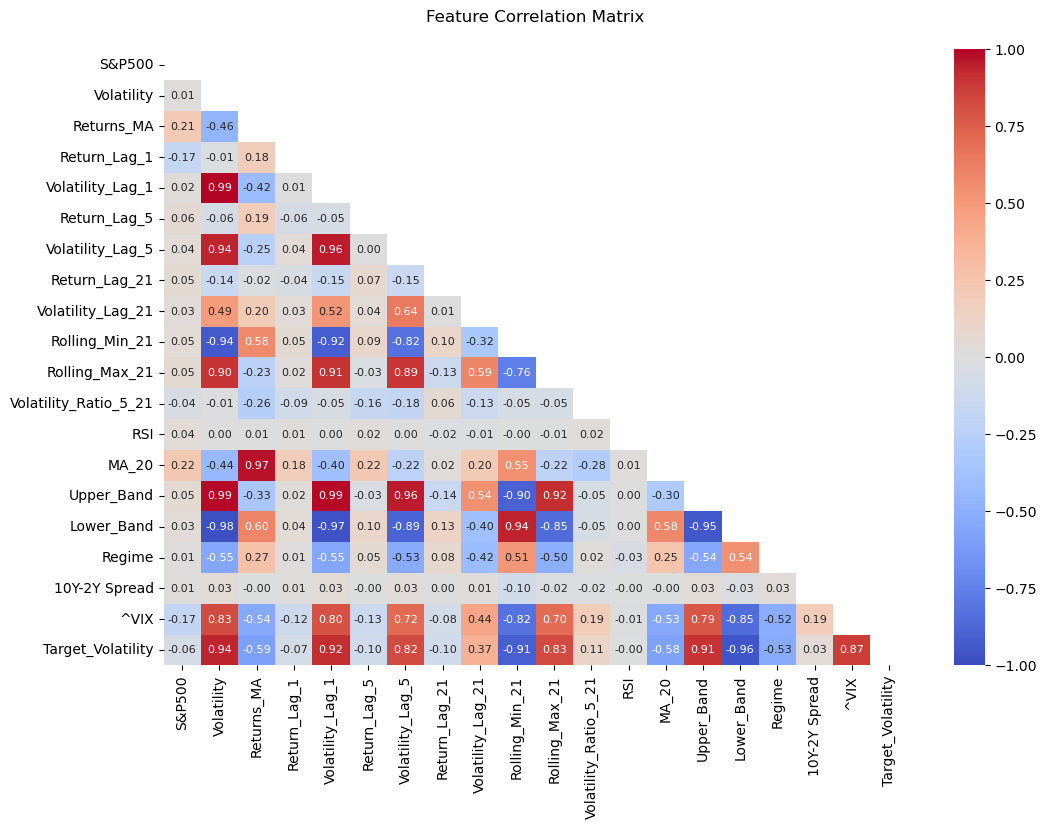

In [84]:
corr_matrix = df_returns_eco.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle 

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    annot_kws={"size":8}, 
    fmt=".2f", 
    cmap='coolwarm', 
    mask=mask,
    vmin=-1, 
    vmax=1
)
plt.title("Feature Correlation Matrix", pad=20)

In [85]:
corr_matrix["Target_Volatility"]

S&P500                  -0.055426
Volatility               0.939291
Returns_MA              -0.589144
Return_Lag_1            -0.072527
Volatility_Lag_1         0.920204
Return_Lag_5            -0.096770
Volatility_Lag_5         0.823516
Return_Lag_21           -0.101467
Volatility_Lag_21        0.373339
Rolling_Min_21          -0.907003
Rolling_Max_21           0.826373
Volatility_Ratio_5_21    0.113222
RSI                     -0.003741
MA_20                   -0.576243
Upper_Band               0.905565
Lower_Band              -0.959199
Regime                  -0.527643
10Y-2Y Spread            0.032316
^VIX                     0.871514
Target_Volatility        1.000000
Name: Target_Volatility, dtype: float64

#### Fixing Collinearity

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  

vif_data = pd.DataFrame()  
vif_data["Feature"] = df_returns_eco.columns  
vif_data["VIF"] = [variance_inflation_factor(df_returns_eco.values, i) for i in range(df_returns_eco.shape[1])]  
print(vif_data.sort_values("VIF", ascending=False))  

                  Feature          VIF
15             Lower_Band          inf
14             Upper_Band          inf
13                  MA_20          inf
1              Volatility  1181.736353
4        Volatility_Lag_1   405.532134
6        Volatility_Lag_5    93.689643
19      Target_Volatility    51.597369
18                   ^VIX    39.946290
9          Rolling_Min_21    39.828518
10         Rolling_Max_21    32.300434
2              Returns_MA    21.117198
8       Volatility_Lag_21    11.342753
11  Volatility_Ratio_5_21     9.616356
16                 Regime     3.511946
0                  S&P500     1.318075
17          10Y-2Y Spread     1.317884
3            Return_Lag_1     1.200264
7           Return_Lag_21     1.153011
5            Return_Lag_5     1.096239
12                    RSI     1.009922


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [88]:
df = df_returns_eco.drop(["Lower_Band", "Upper_Band", "Volatility_Lag_1","Volatility_Lag_5",
                          "Rolling_Min_21", "Rolling_Max_21","^VIX","RSI"], axis=1)

VIX is a forward-looking implied volatility index, while you're modeling realized volatility → this can introduce target leakage, especially if your volatility target overlaps the VIX derivation window

Market-derived forward-looking variables should be avoided when modeling ex-post realized volatility unless you're explicitly modeling implied vs realized spreads

In [90]:
# checking variance inflation factor post reduction
vif_data = pd.DataFrame()  
vif_data["Feature"] = df.columns  
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]  
print(vif_data.sort_values("VIF", ascending=False))  

                  Feature        VIF
11      Target_Volatility  41.237449
1              Volatility  40.258518
2              Returns_MA  20.069150
8                   MA_20  19.330223
6       Volatility_Lag_21   6.638924
7   Volatility_Ratio_5_21   5.847694
9                  Regime   3.095273
0                  S&P500   1.179740
3            Return_Lag_1   1.144324
5           Return_Lag_21   1.122639
10          10Y-2Y Spread   1.112857
4            Return_Lag_5   1.088107


In [91]:
from sklearn.ensemble import RandomForestRegressor  
model_0 = RandomForestRegressor()  

model_0.fit(df.drop("Target_Volatility", axis=1), df["Target_Volatility"])  
pd.DataFrame({  
    'Feature': df.drop("Target_Volatility", axis=1).columns,  
    'Importance': model_0.feature_importances_  
}).sort_values('Importance', ascending=False)  

,Feature,Importance
1,Volatility,0.837112
8,MA_20,0.054205
2,Returns_MA,0.044111
6,Volatility_Lag_21,0.035421
10,10Y-2Y Spread,0.009423
7,Volatility_Ratio_5_21,0.009275
3,Return_Lag_1,0.002886
0,S&P500,0.002818
4,Return_Lag_5,0.002348
5,Return_Lag_21,0.002219


In [92]:
model = RandomForestRegressor()  

model.fit(df.drop("Target_Volatility", axis=1), df["Target_Volatility"])  
pd.DataFrame({  
    'Feature': df.drop("Target_Volatility", axis=1).columns,  
    'Importance': model.feature_importances_  
}).sort_values('Importance', ascending=False)  

,Feature,Importance
1,Volatility,0.833287
2,Returns_MA,0.061085
8,MA_20,0.044122
6,Volatility_Lag_21,0.033020
10,10Y-2Y Spread,0.009302
7,Volatility_Ratio_5_21,0.008619
3,Return_Lag_1,0.002846
0,S&P500,0.002764
4,Return_Lag_5,0.002415
5,Return_Lag_21,0.002414


### Modeling

In [94]:
X = df.drop("Target_Volatility", axis=1)
target = df["Target_Volatility"]
train_size = int(len(X)*0.8)
X_train = X.iloc[:train_size]
y_train = target.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = target.iloc[train_size:]

In [95]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1359, 11), (1359,), (340, 11), (340,))

In [96]:
print(f"Train dates: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test dates: {X_test.index.min()} to {X_test.index.max()}")

Train dates: 2018-03-05 00:00:00 to 2023-08-10 00:00:00
Test dates: 2023-08-11 00:00:00 to 2024-12-19 00:00:00


In [97]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [98]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
regime_train_fit = encoder.fit_transform(X_train["Regime"].values.reshape(-1, 1))
regime_test_fit = encoder.transform(X_test["Regime"].values.reshape(-1, 1))

In [99]:
regime_labels = {
    0: "Choppy_Market",
    1: "Crisis",
    2: "Bull_Market"
}
column_names = [f"{regime_labels[i]}_Regime" for i in encoder.categories_[0]]

In [100]:
regime_train_df = pd.DataFrame(regime_train_fit, columns=column_names, index=X_train.index)
regime_test_df = pd.DataFrame(regime_test_fit, columns=column_names, index=X_test.index)

X_train_aug = pd.concat([X_train.drop(columns="Regime"), regime_train_df], axis=1)
X_test_aug = pd.concat([X_test.drop(columns="Regime"), regime_test_df], axis=1)

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test_aug)

#### Model 1 - Garch

In [103]:
from arch import arch_model

In [104]:
# Garch model treats volatility as latent variable that depends on past squared returns and past volatility
returns_train = df_returns_eco["S&P500"]*100 # Rescaling to [1, 1000] for garch optimizer preference
model_garch = arch_model(returns_train, vol="Garch", p=1, q=1, dist="t")
fit_garch = model_garch.fit(update_freq=5)

Iteration:      5,   Func. Count:     43,   Neg. LLF: 3375.459856128312
Iteration:     10,   Func. Count:     77,   Neg. LLF: 2316.246592550846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2316.2465919648207
            Iterations: 11
            Function evaluations: 83
            Gradient evaluations: 11


In [105]:
fit_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       S&P500   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2316.25
Distribution:      Standardized Student's t   AIC:                           4642.49
Method:                  Maximum Likelihood   BIC:                           4669.68
                                              No. Observations:                 1699
Date:                      Sun, Jun 22 2025   Df Residuals:                     1698
Time:                              22:14:36   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1122  1.793e-02      6.254  4.012e-10 [7.700e-02,  0.147]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0318  8.368e-03      3.805  1.416e-04 [1.544e-02,4.824e-02]
alpha[1]       0.1669  2.435e-02      6.851  7.313e-12     [  0.119,  0.215]
beta[1]        0.8190  2.179e-02     37.595 2.554e-309     [  0.776,  0.862]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.3626      0.955      6.659  2.754e-11 [  4.490,  8.235]
========================================================================

Covariance estimator: robust
"""

In [106]:
fit_garch.params

mu          0.112151
omega       0.031844
alpha[1]    0.166851
beta[1]     0.819020
nu          6.362586
Name: params, dtype: float64

In [107]:
alpha_1 =fit_garch.params["alpha[1]"]
beta_1 = fit_garch.params["beta[1]"]
omega = fit_garch.params["omega"]

persistence = alpha_1 + beta_1
print(f"Model indicates that shock decay extremely slowly and volatility after a market event stays elevated\nα + β = {persistence:.3f} approx close to 1")

Model indicates that shock decay extremely slowly and volatility after a market event stays elevated
α + β = 0.986 approx close to 1


In [108]:
half_life = np.log(0.5)/(np.log(persistence))
half_life

48.710421167203066

μ (mu) the daily mean return is 0.11%

α of 10.1669 demonstrates that 16.7% of yesterday's squared shock affects today's variance

β of 81.9% shows the model heavily relies upon past volatility

A shock takes about 49 days to halve its impact

In [110]:
forecasts = fit_garch.forecast(horizon=5)
daily_vol = np.sqrt(forecasts.variance.iloc[-1])/100 # Reversing scaled optimized effects

annualized_vol = daily_vol * np.sqrt(252) # 252 is the total number of trading days per year and volatility scales with the sqrt of time and this is not adjusted with v/(v-2) because the garch model parameters already covers fat tail intricacies

print(f"Daily Volatility Forecast:\n{daily_vol}\nAnnualized Volatility Forecast (%):\n{annualized_vol}")

Daily Volatility Forecast:
h.1    0.012789
h.2    0.012824
h.3    0.012857
h.4    0.012890
h.5    0.012922
Name: 2024-12-19 00:00:00, dtype: float64
Annualized Volatility Forecast (%):
h.1    0.203027
h.2    0.203568
h.3    0.204100
h.4    0.204623
h.5    0.205138
Name: 2024-12-19 00:00:00, dtype: float64


The forecast of this GARCH(1,1) model fit on the S&P500 data from 2018 to 2024 informs us that the volatility 1 day from the forecast origin (2024-12-19) would be 1.28% and fairly constantly so till day 5, with it being 1.29%. Annualized volatility for horizon 1 of the reference date can be interpreted as follows: should the daily volatility rate @ horizon 1 persist for 252 days at 1.28% (h.1), the annualized rate would be 20.3%, and 20.5% if it persists for 252 days at 1.29% (h.5)

#### Model 2 - LSTM

In [113]:
# Reshaping data for last timesteps
X_train_3d = X_train_aug.values.reshape(X_train_aug.shape[0], 1, X_train_aug.shape[1])
X_test_3d = X_test_aug.values.reshape(X_test_aug.shape[0], 1, X_test_aug.shape[1])

In [114]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X)-seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        y_seq.append(y.iloc[i+seq_len])

    return np.array(X_seq), np.array(y_seq)    

seq_len = 21
X_train_seq, y_train_seq = create_sequences(X_train_aug, y_train, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_aug, y_test, seq_len)

In [115]:
X_train_seq

array([[[ 1.09716176e-02,  2.68997225e-01, -1.73625581e-03, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.63538293e-03,  2.59542839e-01, -5.89967074e-04, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.83991826e-04,  2.11881915e-01,  1.37948765e-03, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.36757775e-02,  2.01401219e-01, -1.29773797e-03, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.25906823e-02,  2.10653540e-01, -1.73472447e-03, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.25359613e-02,  2.15234471e-01, -1.37866848e-03, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.63538293e-03,  2.59542839e-01, -5.89967074e-04, ...,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.83991826e-04,  2.11881915e-01,  1.37948765e-03, ...,
          1.00000000e+00,  0.00000000e

In [116]:
X_train_seq.shape, X_test_seq.shape

((1338, 21, 13), (319, 21, 13))

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [118]:
model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [119]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [120]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - mae: 0.0784 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0563 - val_loss: 4.8737e-04 - val_mae: 0.0176
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0479 - val_loss: 6.0995e-04 - val_mae: 0.0199
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0442 - val_loss: 4.5228e-04 - val_mae: 0.0168
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0405 - val_loss: 3.2846e-04 - val_mae: 0.0139
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0366 - val_loss: 6.1510e-04 - val_mae: 0.0209
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0373 - val_loss: 3.6500e-04 - val_mae: 0.0150
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0357 - val_loss: 2.5630e-04 - val_mae: 0.0127
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

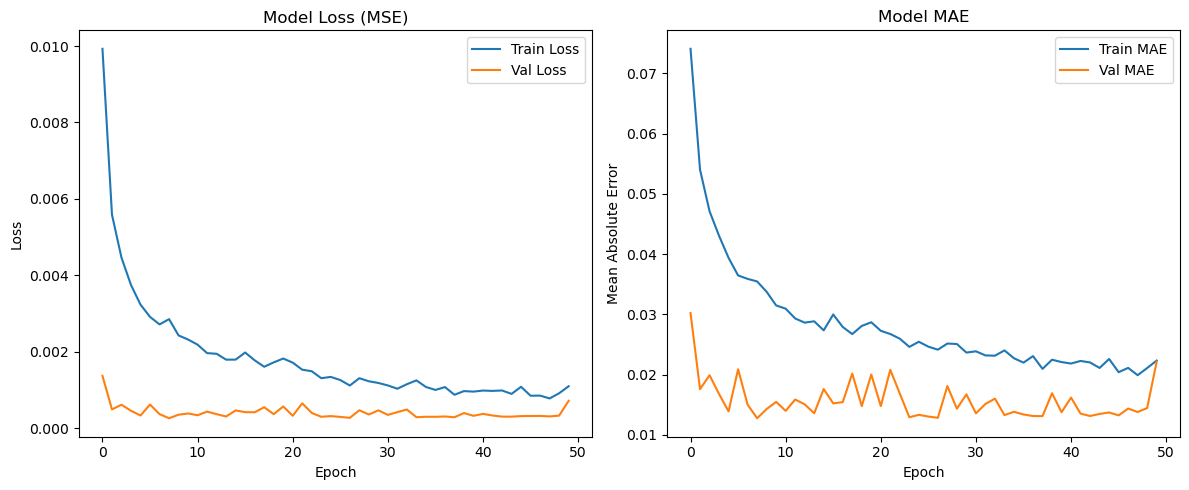

In [121]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [122]:
from sklearn.metrics import mean_squared_error  
y_pred = model.predict(X_test_seq)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print(f"Test RMSE: {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test RMSE: 0.0267


#### Model Interpretation

In [124]:
import shap

In [125]:
X_explain = X_test_seq[200:300]

background = X_train_seq[np.random.choice(X_train_seq.shape[0], 100, replace=False)]

# Build the SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the sample test set
shap_values = explainer.shap_values(X_explain)

In [126]:
print(type(shap_values))
print(type(shap_values[0]))
print(shap_values[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(21, 13, 1)


In [127]:
feature_names = X_train_aug.columns

In [128]:
#shap_values_2d = np.reshape(shap_values, (shap_values.shape[0]*shap_values.shape[1], shap_values.shape[2]))
n_features = X_explain.shape[2]
shap_values_2d = np.reshape(shap_values, (-1,n_features))
feature_values_2d = np.reshape(X_explain, (-1, n_features))

In [129]:
shap_values_2d.shape, feature_values_2d.shape

((2100, 13), (2100, 13))

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/749259910.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")


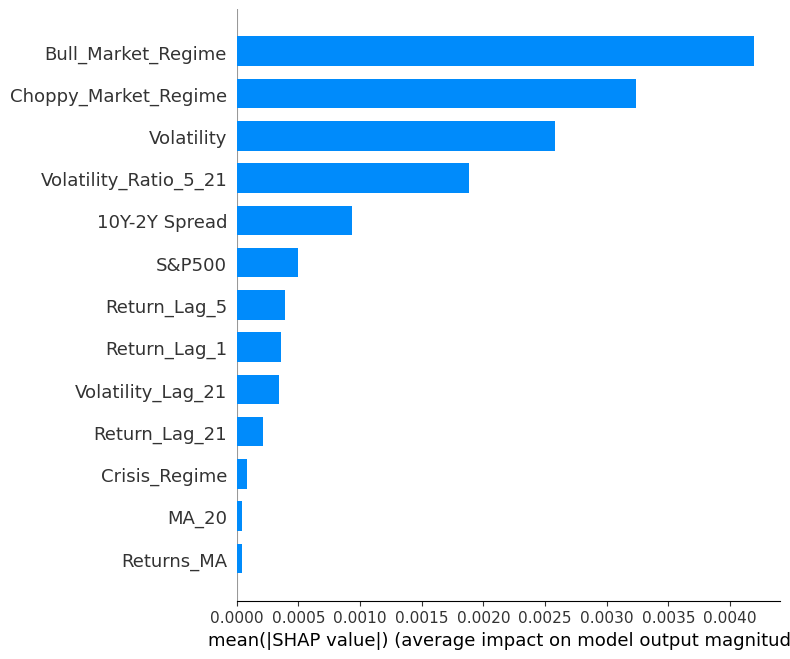

In [130]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")

The Shap barchart provides insight into the feature importance of these variables in the prediction made by the LSTM model, with major highlights being the unconditional volatility, yield spread, bullish market regime, volatility ratio (5 days : 21 days), and the S&P500 logarithmic returns being major drivers for the derived prediction.

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/3494414066.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")


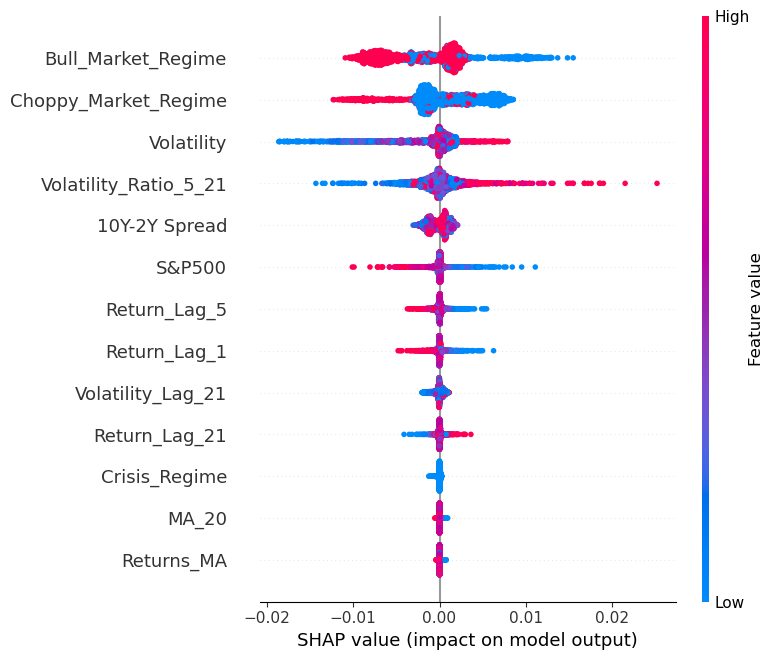

In [132]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")

This shap beeswarm visualisation shows that high values of unconditional volatility and volatility ratio (5 days : 21 days) resulted in a positive drive on the prediction, that is, increased the prediction output, and lower values of regime and returns factored in the net positive move on the predicted values of the target volatility (increased prediction output) and vice versa.

In [134]:
feature_importance = pd.DataFrame({
    "Feature": X_train_aug.columns,
    "SHAP_Value": np.abs(shap_values_2d).mean(axis=0)  # Avg magnitude
}).sort_values("SHAP_Value", ascending=False)

In [135]:
feature_importance

,Feature,SHAP_Value
12,Bull_Market_Regime,0.004196
10,Choppy_Market_Regime,0.003240
1,Volatility,0.002582
7,Volatility_Ratio_5_21,0.001882
9,10Y-2Y Spread,0.000933
0,S&P500,0.000500
4,Return_Lag_5,0.000387
3,Return_Lag_1,0.000362
6,Volatility_Lag_21,0.000340
5,Return_Lag_21,0.000215


#### Model 3 - Hybrid

Garch model captures the structure and hesteroskedacity of the S&P500 volatility series with interpretable parameter and LSTM provides strong non-linear capture and temporal dynamics especially in high-dimensional or nonstationary settings.

Lets integrate these two concepts together. A few things to note: Garch Volatility and Garch Residuals will now be included as features

Garch Volatility is the time varying estimate of volatility at each time step - this introduces the already calculated variables α0, α1, and β1 

Garch Residual is the difference between the actual return and the model's predicted mean, scaled by volatility. It measures unexplained shocks after accounting for volatility

In [138]:
garch_residuals = fit_garch.resid
garch_volatility = fit_garch.conditional_volatility

In [139]:
split_idx = int(len(garch_volatility)*0.8)

# Garch Volatility
garch_vol_train = garch_volatility[:split_idx]
garch_vol_test = garch_volatility[split_idx:]

# Garch Residual
garch_res_train = garch_residuals[:split_idx]
garch_res_test = garch_residuals[split_idx:]

In [140]:
y_pred_lstm = model.predict(X_test_seq)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [141]:
y_pred_lstm = y_pred_lstm.flatten()

In [142]:
len(y_test_seq), len(y_pred_lstm), len(garch_vol_test), len(garch_res_test) # Reason for length difference is because of the 21 days window shift on the sequence batch

(319, 319, 340, 340)

In [163]:
garch_aligned_vol = garch_vol_test.iloc[seq_len:seq_len+len(y_test_seq)]
garch_aligned_res = garch_res_test.iloc[seq_len:seq_len+len(y_test_seq)]

In [165]:
len(garch_aligned_vol), len(garch_aligned_res)

(319, 319)

All matched up

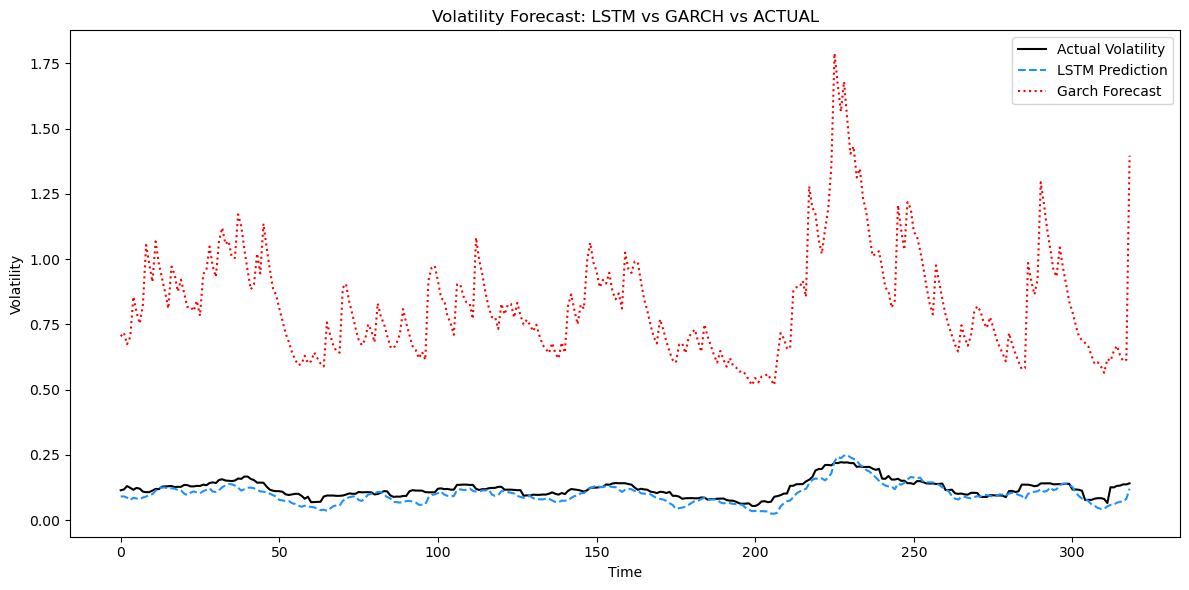

In [173]:
plt.figure(figsize=(12,6))

plt.plot(y_test_seq, label="Actual Volatility", color="black", linewidth=1.5)
plt.plot(y_pred_lstm, label="LSTM Prediction", color="dodgerblue", linestyle="--")
plt.plot(garch_aligned_vol.values, label="Garch Forecast", color="red", linestyle=":")

plt.title("Volatility Forecast: LSTM vs GARCH vs ACTUAL")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

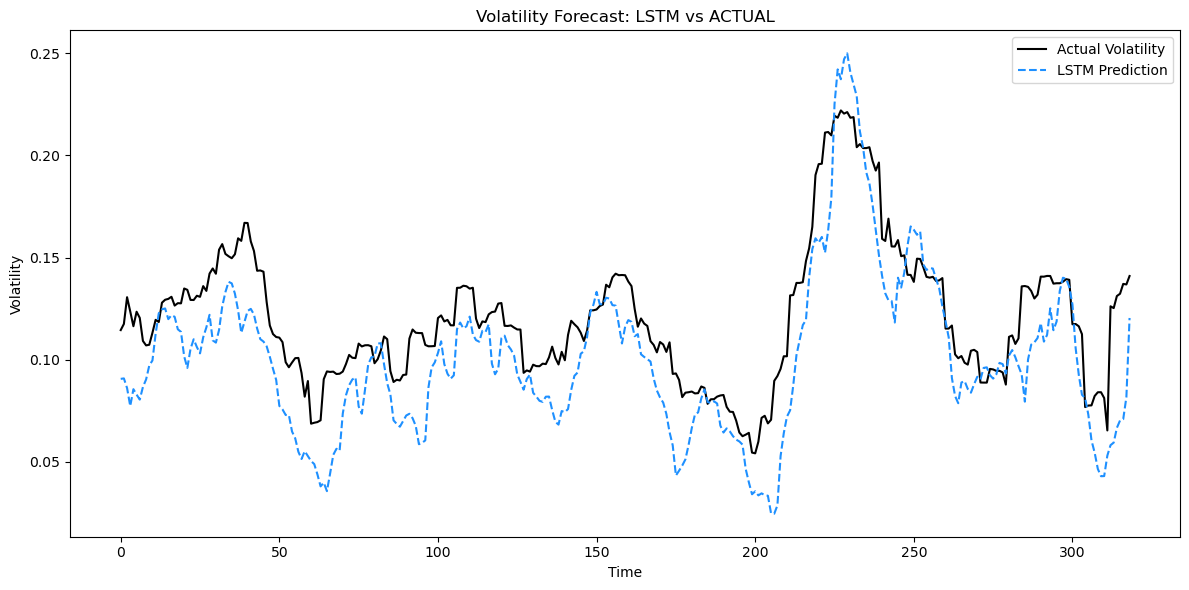

In [175]:
plt.figure(figsize=(12,6))

plt.plot(y_test_seq, label="Actual Volatility", color="black", linewidth=1.5)
plt.plot(y_pred_lstm, label="LSTM Prediction", color="dodgerblue", linestyle="--")

plt.title("Volatility Forecast: LSTM vs ACTUAL")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

This shows us that the lstm model tracks the actual volatility closely, even predicting almost closely the same period of volatility spikes around time index ~230–250. The Garch model on the other hand overestimates volatility and eventually during spikes it overshoots the magnitude (this could be due to persistence parameter α + β being close to 1).

In [178]:
len(garch_volatility), len(target)

(1699, 1699)

In [180]:
len(X_train_aug)

1359

In [182]:
X_train_aug["Garch_Volatilty"] = garch_vol_train.values
X_test_aug["Garch_Volatilty"] = garch_vol_test.values

X_train_aug["Garch_Residuals"] = garch_res_train.values
X_test_aug["Garch_Residuals"] = garch_res_test.values

In [184]:
seq_len = 21
X_train_seq, y_train_seq = create_sequences(X_train_aug, y_train, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_aug, y_test, seq_len)

model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [185]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - mae: 0.0962 - val_loss: 4.2512e-04 - val_mae: 0.0162
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - mae: 0.0595 - val_loss: 8.5803e-04 - val_mae: 0.0250
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mae: 0.0538 - val_loss: 4.0555e-04 - val_mae: 0.0169
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0443 - val_loss: 3.3340e-04 - val_mae: 0.0143
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0409 - val_loss: 5.8591e-04 - val_mae: 0.0210
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0408 - val_loss: 4.0612e-04 - val_mae: 0.0165
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0353 - val_loss: 3.2090e-04 - val_mae: 0.0135
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0332 - val_loss: 3.3351e-04 - val_mae: 0.0144
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

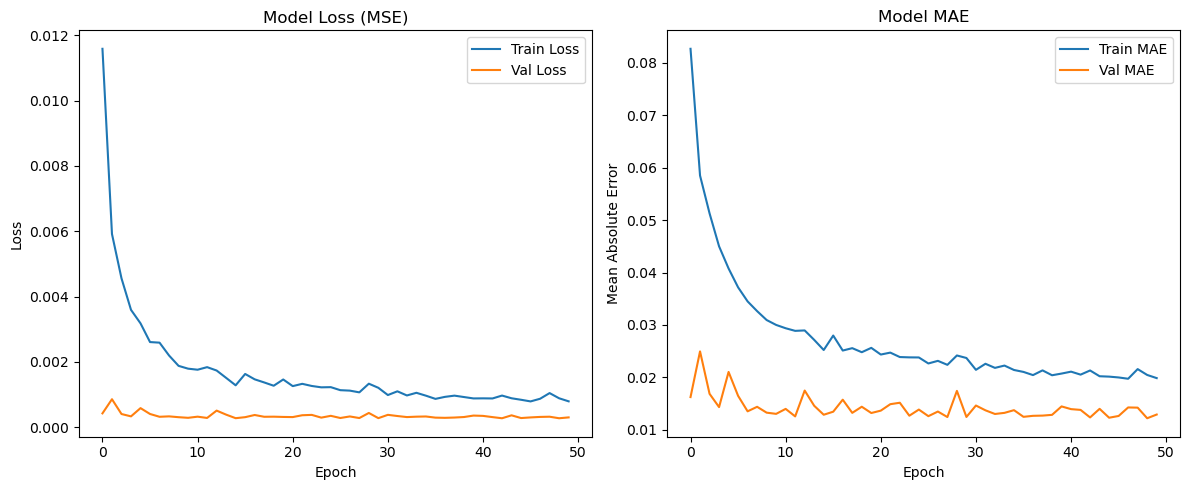

In [187]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [188]:
from sklearn.metrics import mean_squared_error  
y_pred = model.predict(X_test_seq)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print(f"Test RMSE: {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test RMSE: 0.0174


In [189]:
X_explain = X_test_seq[200:300]

background = X_train_seq[np.random.choice(X_train_seq.shape[0], 100, replace=False)]

# Build the SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the sample test set
shap_values = explainer.shap_values(X_explain)

In [190]:
feature_names = X_train_aug.columns
n_features = X_explain.shape[2]
shap_values_2d = np.reshape(shap_values, (-1,n_features))
feature_values_2d = np.reshape(X_explain, (-1, n_features))

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/749259910.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")


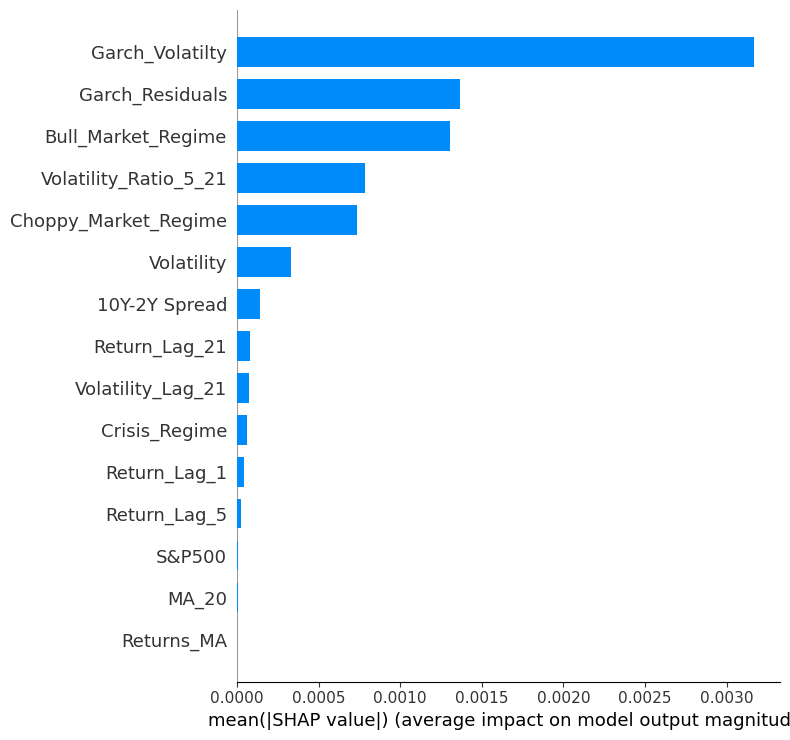

In [191]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_34796/3494414066.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")


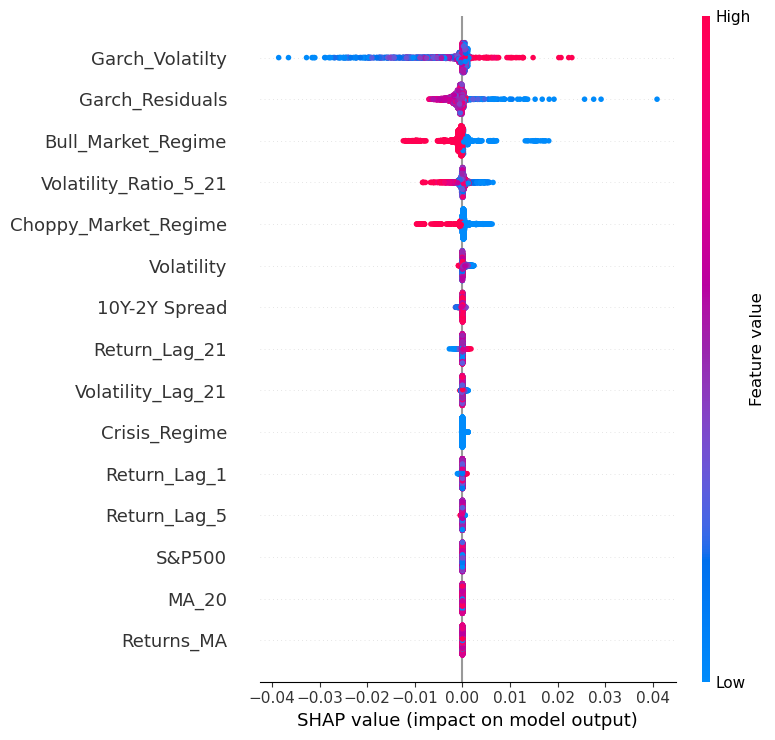

In [192]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")

In [193]:
feature_importance = pd.DataFrame({
    "Feature": X_train_aug.columns,
    "SHAP_Value": np.abs(shap_values_2d).mean(axis=0)  # Avg magnitude
}).sort_values("SHAP_Value", ascending=False)

In [194]:
feature_importance

,Feature,SHAP_Value
13,Garch_Volatilty,0.003167
14,Garch_Residuals,0.001364
12,Bull_Market_Regime,0.001303
7,Volatility_Ratio_5_21,0.000782
10,Choppy_Market_Regime,0.000738
1,Volatility,0.000329
9,10Y-2Y Spread,0.000142
5,Return_Lag_21,0.000082
6,Volatility_Lag_21,0.000074
11,Crisis_Regime,0.000059


In [195]:
y_pred_lstm_2 = model.predict(X_test_seq)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


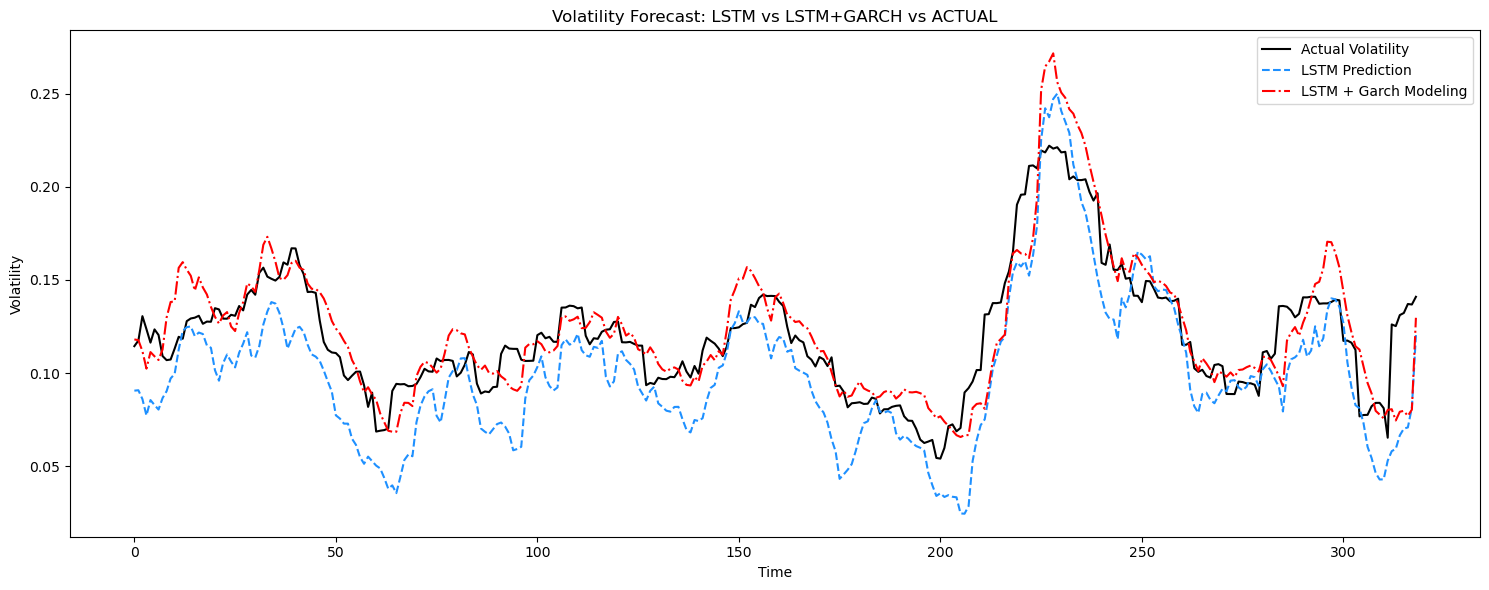

In [196]:
plt.figure(figsize=(15,6))

plt.plot(y_test_seq, label="Actual Volatility", color="black", linewidth=1.5)
plt.plot(y_pred_lstm, label="LSTM Prediction", color="dodgerblue", linestyle="--")
#plt.plot(garch_aligned.values, label="Garch Forecast", color="red", linestyle=":")
plt.plot(y_pred_lstm_2, label="LSTM + Garch Modeling", color="red", linestyle="-.")

plt.title("Volatility Forecast: LSTM vs LSTM+GARCH vs ACTUAL")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()